In [25]:
from __future__ import division
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb
import pickle
import time
import datetime
import math
import gc
import warnings
warnings.filterwarnings('ignore')

In [26]:
########################################### Helper function ###########################################

In [27]:
def spilt_local_train_test(df, train_size, test_size):
    local_train = df[:train_size]
    local_test = df[train_size:train_size + test_size]
    return local_train, local_test


def get_model_input_data(train, test, is_local):
    feat = ['ip', 'app', 'device', 'os', 'channel', 'hour']
    for f in feat:
        if f not in predictors:
            predictors.append(f)
    train_x = train[predictors]
    train_y = train.is_attributed.values
    if is_local == 1:
        test_x = test[train_x.columns.values]
        test_y = test.is_attributed.values
        return train_x, train_y, test_x, test_y
    else:
        test_x = test[train_x.columns.values]
        return train_x, train_y, test_x

In [28]:
def lgb_cv(train_feature, train_label, test_feature, test_label, params, folds, rounds):
    start = time.clock()
    print(train_feature.columns)
    params['scale_pos_weight'] = float(len(train_label[train_label == 0])) / len(train_label[train_label == 1])
    dtrain = lgb.Dataset(train_feature, label=train_label, categorical_feature=['app', 'device', 'os', 'channel', 'hour'])
    dtest = lgb.Dataset(test_feature, label=test_label, categorical_feature=['app', 'device', 'os', 'channel', 'hour'])
    num_round = rounds
    print('LightGBM run cv: ' + 'round: ' + str(rounds))
    res = lgb.train(params, dtrain, num_round, valid_sets=[dtest], valid_names=['test'], verbose_eval=1, early_stopping_rounds=20)
    elapsed = (time.clock() - start)
    print('Time used:', elapsed, 's')
    return res.best_iteration, res.best_score['test']['auc'], res


def lgb_predict(train_feature, train_label, test_feature, rounds, params):
    dtrain = lgb.Dataset(train_feature, label=train_label, categorical_feature=['app', 'device', 'os', 'channel', 'hour'])
    num_round = rounds
    model = lgb.train(params, dtrain, num_round, valid_sets=[dtrain], verbose_eval=1)
    predict = model.predict(test_feature)
    return model, predict

In [29]:
def store_result(test_index, pred, name):
    result = pd.DataFrame({'click_id': test_index, 'is_attributed': pred})
    result.to_csv(name + '.csv', index=False, sep=',')
    return result

In [30]:
class GaussianSmoth(object):
    def __init__(self, alpha=0, beta=0):
        self.alpha = alpha
        self.beta = beta

    def update_moment(self, tries, success):
        '''estimate alpha, beta using moment estimation'''
        mean, var = self.__compute_moment(tries, success)
        self.alpha = (mean + 0.000001) * ((mean + 0.000001) * (1.000001 - mean) / (var + 0.000001) - 1)
        self.beta = (1.000001 - mean) * ((mean + 0.000001) * (1.000001 - mean) / (var + 0.000001) - 1)
        print(self.alpha, self.beta)
        return (self.alpha + success) / (self.alpha + self.beta + tries)

    def __compute_moment(self, tries, success):
        # Cal mean and variance
        '''moment estimation'''
        ctr_list = []
        mean = (success / tries).mean()
        if len(tries) == 1:
            var = 0
        else:
            var = (success / tries).var()
        return mean, var

In [31]:
def log(info):
    print (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' ' + str(info))


def log_shape(train, test):
    log('Train data shape: %s' % str(train.shape))
    log('Test data shape: %s' % str(test.shape))

In [32]:
########################################### Read data ###########################################

In [33]:
log('Read data...')
dtypes = {
    'click_id': 'uint32',
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8'
}
train = pd.read_csv('ProcessedData.csv', header=0, sep=',',dtype=dtypes,nrows = 10000000)
test_supplement = pd.read_csv( 'test_supplement.csv', header=0, sep=',', dtype=dtypes, nrows=1000000)
gc.collect()
log('Read data done!')
log_shape(train, test_supplement)

2019-05-11 17:36:21 Read data...
2019-05-11 17:37:44 Read data done!
2019-05-11 17:37:44 Train data shape: (10000000, 43)
2019-05-11 17:37:44 Test data shape: (1000000, 7)


In [34]:
log('Read test...')
test = pd.read_csv('ProcessedTestData.csv', header=0, sep=',', dtype=dtypes)
log('Test data original shape: ' + str(test.shape))

2019-05-11 17:37:44 Read test...
2019-05-11 17:37:50 Test data original shape: (1000000, 42)


In [52]:
test.drop(['date'], axis = 1, inplace= True)

In [53]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 41 columns):
Unnamed: 0                                 1000000 non-null int64
ip                                         1000000 non-null uint32
app                                        1000000 non-null uint16
device                                     1000000 non-null uint16
os                                         1000000 non-null uint16
channel                                    1000000 non-null uint16
click_time                                 1000000 non-null int64
hour                                       1000000 non-null int64
day                                        1000000 non-null int64
minute                                     1000000 non-null int64
second                                     1000000 non-null int64
in_test_hh                                 1000000 non-null int64
app_count                                  1000000 non-null int64
ip_count                 

In [36]:
########################################### Split dataset for local ###########################################

In [37]:
log('Split dataset to get local train/test set...')

local_train_size = 9900000  # 182403890
local_test_size = 100000
local_train, local_test = spilt_local_train_test(train, local_train_size, local_test_size)
log('Split dataset to get local train/test set done!')

log('================================= Local data info =====================================')
log('Local train shape:' + str(local_train.shape))
log('Local test shape:' + str(local_test.shape))
log('Local train label ratio (0-1):' + str(local_train.is_attributed.value_counts().values * 1.0 / local_train.shape[0]))
log('Local train label number (0-1):' + str(local_train.is_attributed.value_counts().values))
log('Local train min/max date:' + str(local_train.date.min()) + ',' + str(local_train.date.max()))
log('Local test min/max date:' + str(local_test.date.min()) + ',' + str(local_test.date.max()))
log('=======================================================================================')

2019-05-11 17:37:50 Split dataset to get local train/test set...
2019-05-11 17:37:50 Split dataset to get local train/test set done!
2019-05-11 17:37:50 ================================= Local data info =====================================
2019-05-11 17:37:50 Local train shape:(9900000, 43)
2019-05-11 17:37:50 Local test shape:(100000, 43)
2019-05-11 17:37:50 Local train label ratio (0-1):[0.99813152 0.00186848]
2019-05-11 17:37:50 Local train label number (0-1):[9881502   18498]
2019-05-11 17:37:51 Local train min/max date:2017-11-06 14:32:21,2017-11-07 00:10:25
2019-05-11 17:37:51 Local test min/max date:2017-11-07 00:10:25,2017-11-07 00:12:03
2019-05-11 17:37:51 =======================================================================================


In [38]:
# print(local_train.head())

In [39]:
local_train_y = local_train.is_attributed.values
local_train_x = local_train.drop(['is_attributed','date'], axis = 1)
local_test_y = local_test.is_attributed.values
local_test_x = local_test.drop(['is_attributed','date'], axis = 1)

In [40]:
########################################### LigthGBM ###########################################

In [41]:
config_lgb = {
    'rounds': 100,
    'folds': 5
}

params_lgb = {
    'boosting_type': 'gbdt',
    'objective': 'xentropy',
    'metric': 'auc',
    'learning_rate': 0.02,
    # 'is_unbalance': 'true',  # Because training data is unbalance (replaced with scale_pos_weight)
    'scale_pos_weight': 200,  # Because training data is extremely unbalanced
    'num_leaves': 31,  # We should let it be smaller than 2^(max_depth)
    'max_depth': -1,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 128,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # Frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0.99,  # L1 regularization term on weights
    'reg_lambda': 0.9,  # L2 regularization term on weights
    'nthread': 24,
    'verbose': 1,
    'seed': 8
}

In [42]:
local_test_x.shape

(100000, 41)

In [43]:
iterations_lgb, best_score_lgb, model_cv_lgb = lgb_cv(local_train_x, local_train_y, local_test_x, local_test_y, params_lgb, config_lgb['folds'], config_lgb['rounds'])

Index(['Unnamed: 0', 'ip', 'app', 'device', 'os', 'channel', 'click_time',
       'hour', 'day', 'minute', 'second', 'in_test_hh', 'app_count',
       'ip_count', 'channel_count', 'os_count', 'ip_device_count',
       'day_hour_app_count', 'app_channel_count', 'ip_day_in_test_hh_count',
       'ip_day_hour_count', 'os_device_count', 'ip_os_day_hour_count',
       'ip_device_day_hour_count', 'ip_app_os_count', 'ip_app_channel_var',
       'ip_app_os_var', 'ip_app_device_var', 'app_countAccum', 'ip_countAccum',
       'day_countAccum', 'hour_countAccum', 'app_uniq_ip_countUniq',
       'app_device_os_channel_uniq_ip_countUniq', 'ip_uniq_channel_countUniq',
       'ip_uniq_app_countUniq', 'ip_uniq_os_countUniq', 'ip_os_nextClick',
       'ip_device_os_nextClick', 'ip_app_device_os_nextClick',
       'ip_app_device_os_channel_nextClick'],
      dtype='object')
LightGBM run cv: round: 100
[1]	test's auc: 0.899024
Training until validation scores don't improve for 20 rounds.
[2]	test's auc: 

In [54]:
pred_lgb = model_cv_lgb.predict(test)

In [56]:
print(pred_lgb)

[0.00235643 0.00056724 0.00062678 ... 0.00100398 0.00072803 0.00195787]


In [85]:
importance_lgb = sorted(zip(online_train_x.columns, model_cv_lgb.feature_importance("gain")), key=lambda x: x[1], reverse=True)
importance_lgb = pd.DataFrame({'feature': importance_lgb})
importance_lgb = importance_lgb.apply(lambda x: pd.Series(x['feature']), axis=1)
importance_lgb.columns = ['feature', 'importance']
importance_lgb.to_csv('importance-lgb-20180507-%f(r%d).csv' % (best_score_lgb, iterations_lgb), index=False)

In [19]:
res_lgb = store_result(pd.read_csv('test.csv', header=0, sep=',', usecols=['click_id'], nrows=1000000).click_id.astype(int), pred_lgb, '20190511-lgb-%f(r%d)' % (best_score_lgb, iterations_lgb))

NameError: name 'pred_lgb' is not defined

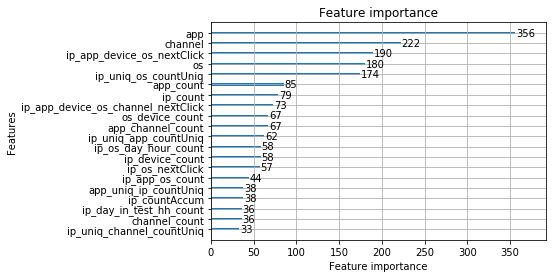

In [64]:
ax = lgb.plot_importance(model_cv_lgb, max_num_features=20)#max_features表示最多展示出前10个重要性特征，可以自行设置
plt.show()
imp_features = test.columns.values.tolist()
improtance_model = model_cv_lgb.feature_importance('gain')
improtance_model = pd.DataFrame({'feature': imp_features,'importance':improtance_model})
improtance_model.to_csv('importance-lgb-20190511-%f(r%d).csv' % (best_score_lgb, iterations_lgb), index=False)

In [ ]:
########### Model save and reload - begin ###########

In [66]:
# Save model
log('Save model...')
model_cv_lgb.save_model('lgb-20190511-%f(r%d).txt' % (best_score_lgb, iterations_lgb))
log('Model best score:' + str(best_score_lgb))
log('Model best iteration:' + str(iterations_lgb))
log('Save model done!')

2019-05-11 18:23:12 Save model...
2019-05-11 18:23:12 Model best score:0.9717892916079822
2019-05-11 18:23:12 Model best iteration:71
2019-05-11 18:23:12 Save model done!


In [75]:
# # Reload model
# model_lgb = lgb.Booster(model_file=root_path + 'data/output/model/lgb-0.981609(r2100).txt')

In [76]:
########### Model save and reload - end ###########